In [1]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime, timedelta
from matplotlib import pyplot as plt


warnings.filterwarnings('ignore')

## Import Data

In [2]:
telescopes = ['12-meter','alma','apex','aste','iram','jcmt','lmt','sma','smt','spt']

In [3]:
starttime = datetime(2019,10,3,6)
endtime = datetime(2019,10,14,0) # not included
timestamps = np.arange(starttime, endtime, 
                       timedelta(hours=6)).astype(datetime)
databook = {}
for ts in telescopes:
    databook[ts] = dict.fromkeys(timestamps)

In [4]:
for ts in telescopes:
    for t in timestamps:
        filepath = "data/"+ ts +"/"+ t.strftime("%Y%m%d_%H:%M:%S")
        try:
            df = pd.read_csv(filepath, delim_whitespace=True, skiprows = 1, header = None)
            df.columns = ["date", "tau225", "Tb[k]", "pwv[mm]", "lwp[kg*m^-2]","iwp[kg*m^-2]","o3[DU]"]
            df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d_%H:%M:%S")
            databook[ts][t] = df
        except FileNotFoundError:
            databook[ts][t] = None
# databook is a dictionary of dictionaries of dataframes 
# keys: telescope names
# values: dictionaries of dataframes for one telescope
# databook[telescope_name] is a dictionary of dataframes for one telescope
# keys: timestamps when the forecast is made
# values: forecast dataframe (None if missing)

All our available data is stored in `databook`(a dict of dictionaries):

`databook` indexing:

`databook[telescope_name][timestamp]` is a dataframe of the 16-day forward forecast made at `timestamp` for `telescope_name`. See example below:

In [5]:
print(telescopes[0],timestamps[1])
(databook[telescopes[0]][timestamps[1]]).head()

12-meter 2019-10-03 12:00:00


,date,tau225,Tb[k],pwv[mm],lwp[kg*m^-2],iwp[kg*m^-2],o3[DU]
0,2019-10-03 12:00:00,0.76472,154.45,12.945,0.000000,0.000000,252.87
1,2019-10-03 13:00:00,0.76153,154.05,12.879,0.000000,0.000000,253.39
2,2019-10-03 14:00:00,0.76019,153.85,12.872,0.000000,0.000000,253.79
3,2019-10-03 15:00:00,0.00000,0.00,0.000,0.000000,0.000000,0.00
4,2019-10-03 16:00:00,0.90973,171.53,15.391,0.006263,0.000001,253.53


## Plot forecast

For the EDA below, we use the data for telescope('apex') as an example. 

In [21]:
data_telescope = databook['apex']

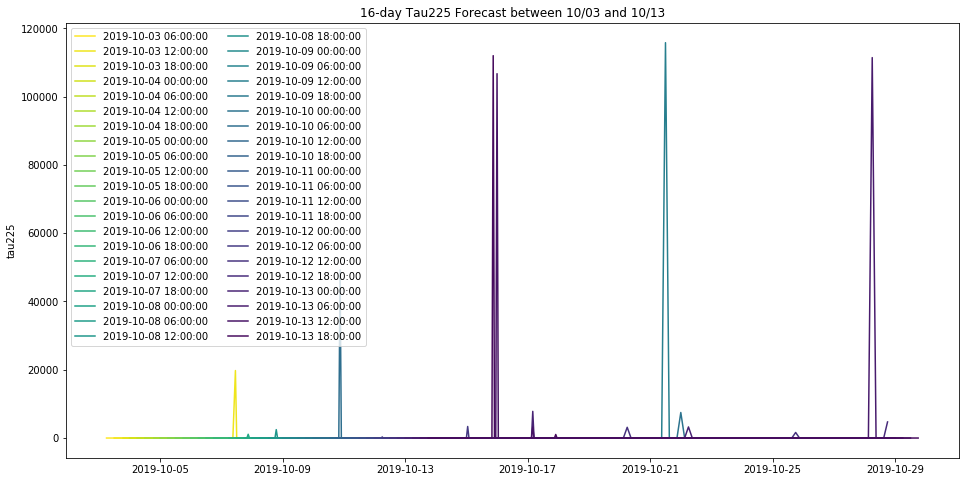

In [28]:
import matplotlib.cm as cm
#cycle through colors from a continuous color map
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(1,0,len(timestamps))))

plt.figure(figsize = (16,8))
for t in data_telescope:
    df = data_telescope[t]
    if df is not None:
        plt.plot(df['date'], df['tau225'], label=t)
plt.legend(ncol = 2)
plt.title("16-day Tau225 Forecast between 10/03 and 10/13")
plt.ylabel("tau225")
plt.show()

With the use of color map, we denotes the more recent the prediction the deeper

As we can see, there are some really high spikes. Are these outliers? (need to be validated)

Zoom in a little bit:

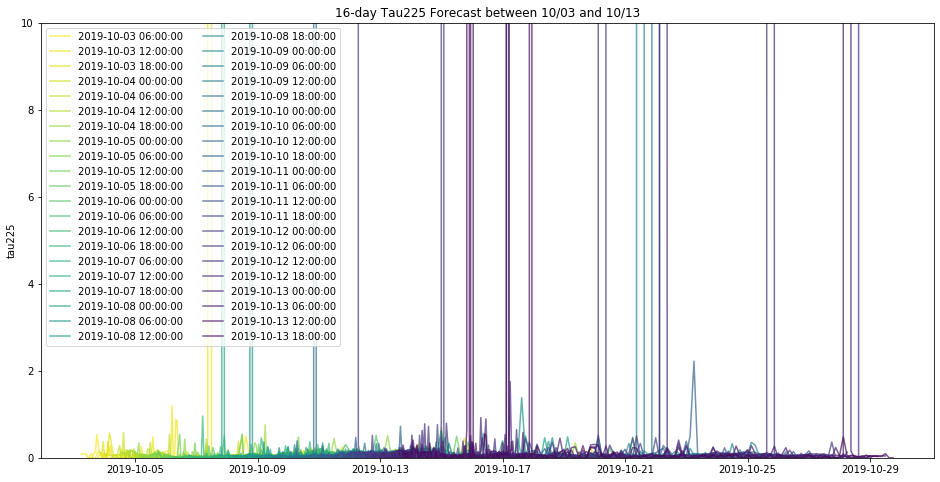

In [29]:
plt.figure(figsize = (16,8))
for t in data_telescope:
    df = data_telescope[t]
    if df is not None:
        plt.plot(df['date'], df['tau225'], label=t, alpha = 0.7)
plt.legend(ncol = 2)
plt.title("16-day Tau225 Forecast between 10/03 and 10/13")
plt.ylabel("tau225")
plt.ylim(0,10)
plt.show()

It seems that the forecast has some variance.

## Compute variance

We still use the weather prediction for 'apex' as the example to compute the variance.

In [239]:
df_all = pd.concat([data_telescope[t] for t in data_telescope], axis =0)
df_tau_all = df_all.groupby('date').agg({'tau225':lambda x: list(x)})

df_tau_all['tau225_mean'] = df_tau_all['tau225'].apply(lambda x: np.mean(x))
df_tau_all['tau225_min'] = df_tau_all['tau225'].apply(lambda x: np.min(x))
df_tau_all['tau225_max'] = df_tau_all['tau225'].apply(lambda x: np.max(x))
df_tau_all['tau225_true'] = df_tau_all['tau225'].apply(lambda x: x[-1])
df_tau_all['tau225_latest'] = df_tau_all['tau225'].apply(lambda x: x[-2] if len(x)>1 else x[-1])

df_tau_all.reset_index(inplace = True)

In [240]:
df_tau_all.iloc[20:25]

,date,tau225,tau225_mean,tau225_min,tau225_max,tau225_true,tau225_latest
20,2019-10-04 02:00:00,"[0.0, 0.068749, 0.0, 0.081689]",0.037610,0.000000,0.081689,0.081689,0.000000
21,2019-10-04 03:00:00,"[0.35504, 0.37931, 0.069635]",0.267995,0.069635,0.379310,0.069635,0.379310
22,2019-10-04 04:00:00,"[0.0, 0.053272, 0.56715]",0.206807,0.000000,0.567150,0.567150,0.053272
23,2019-10-04 05:00:00,"[0.0, 0.2847, 0.43477, 0.055701]",0.193793,0.000000,0.434770,0.055701,0.434770
24,2019-10-04 06:00:00,"[0.0, 0.0, 0.05424299999999999, 0.0]",0.013561,0.000000,0.054243,0.000000,0.054243


Here we re-arrange the dataframe. Each row collected all the prediction for the time in 'date' as a list (here we only use 'tau225' for now. We also calculate the mean, range(min, max) and use the last prediction value as the true weather condition(predicting the weather on the time we are on now), and the second last prediction as the latest prediction.

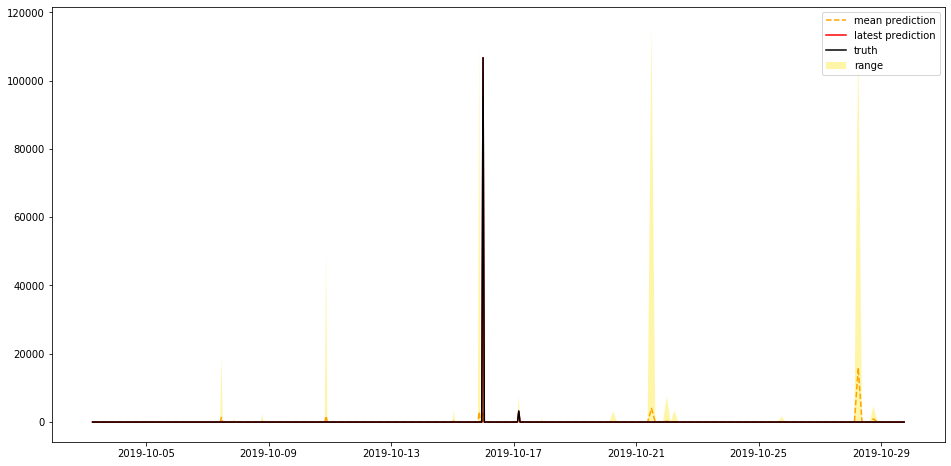

In [259]:
plt.figure(figsize = (16,8))
plt.plot(df_tau_all.date, df_tau_all.tau225_mean, c = 'orange', ls = '--', label = 'mean prediction')
plt.plot(df_tau_all.date, df_tau_all.tau225_latest, c = 'r', label = 'latest prediction')
plt.plot(df_tau_all.date, df_tau_all.tau225_latest, c = 'black', label = 'truth')
plt.fill_between(df_tau_all.date, df_tau_all.tau225_max, df_tau_all.tau225_min, alpha = 0.4, label = 'range');
plt.legend();

Here we use the yellow area to denote the range, blue represents the lastest prediction and red represnts the weather predictions. Since here are some really strong spikes, it's better for us to zoom in a little bit to see the relationship between those three.

We chose a period in the middle (10/12 09:00 to 10/15 00:00) as it have enough predictions and are well-representative.

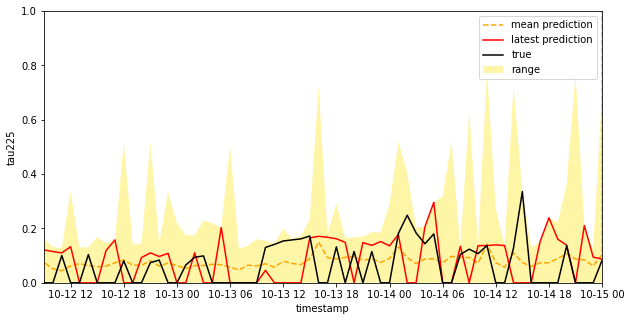

In [258]:
plt.figure(figsize = (10,5))
plt.plot(df_tau_all.date, df_tau_all.tau225_mean, c = 'orange', ls = '--',label = 'mean prediction')
plt.plot(df_tau_all.date, df_tau_all.tau225_latest, c = 'r', label = 'latest prediction')
plt.plot(df_tau_all.date, df_tau_all.tau225_true, c = 'black', label = 'true')
plt.fill_between(df_tau_all.date, df_tau_all.tau225_max, df_tau_all.tau225_min, alpha = 0.4,label = 'range');
plt.ylim(0,1)
plt.xlim('2019-10-12 9:00:00', '2019-10-15 00:00:00')
plt.ylim()
plt.legend(fontsize = 10)
plt.ylabel('tau225', fontsize = 10)
plt.xlabel('timestamp', fontsize = 10);

From the plot above we can see that, we got a range of predictions for each time. Also, the latest prediction for each time also differs from the mean prediction greatly, and also differs from the true weather prediction.

One other thing also noticable is that there are several zeros for the true weather condition.

**Small Take-away**
- Things needs further check:
    - the spikes
    - the zeros
- There are lot of freedom in how to choose the prediction and how to measure the uncertainty.

## Baseline Model

For the baseline, we do not take any uncertainty into account. We only use the latest prediction for each time.

**1. For each telescope, calculate their reward for the day according to their schedule.**


According to the scheduling file that EHT has sent to us, we calculate the reward for each telescope only based on the following schedule provided by EHT for Tue  24 Apr 2018 (whether the telescopes will be triggered all the time as the schedule needs further confirmation)

Station            |Obs. start time (UTC)  |    Obs end time(UTC) |     Total GBytes
-------------------|------------------------|-----------------------|-----------------
  ALMA             |  03:02:00              |  13:09:00             |  22830.7
  APEX             |  03:02:00              |  15:11:00             |  26153.8
  PICOVEL          |  03:02:00              |  07:25:00             |  8800.0
  SPT              |  03:02:00              |  15:00:00             |  26953.8
  LMT              |  05:53:00              |  15:45:00             |  22215.3
  SMTO             |  07:22:00              |  15:45:00             |  18030.7
  JCMT             |  09:42:00              |  15:45:00             |  12123.0
  SMAP             |  09:42:00              |  15:45:00             |  12123.0

Due to the property of our data, we approximate the time to o'clock as following:

Station            |Obs. start time (UTC)  |    Obs end time(UTC) |     Total GBytes
-------------------|------------------------|-----------------------|-----------------
  ALMA             |  03:00:00              |  13:00:00             |  22830.7
  APEX             |  03:00:00              |  15:11:00             |  26153.8
  PICOVEL          |  03:00:00              |  07:25:00             |  8800.0
  SPT              |  03:00:00              |  15:00:00             |  26953.8
  LMT              |  06:00:00              |  15:45:00             |  22215.3
  SMTO             |  08:00:00              |  15:45:00             |  18030.7
  JCMT             |  10:00:00              |  15:45:00             |  12123.0
  SMAP             |  10:00:00              |  15:45:00             |  12123.0

In [260]:
df_all.

,date,tau225,Tb[k],pwv[mm],lwp[kg*m^-2],iwp[kg*m^-2],o3[DU]
0,2019-10-03 06:00:00,0.091228,27.319,1.92190,0.000000,0.000000,257.25
1,2019-10-03 07:00:00,0.088577,26.679,1.86690,0.000000,0.000000,257.70
2,2019-10-03 08:00:00,0.086713,26.216,1.82570,0.000000,0.000000,258.47
3,2019-10-03 09:00:00,0.089006,26.744,1.87750,0.000000,0.000000,259.20
4,2019-10-03 10:00:00,0.086772,26.217,1.82080,0.000000,0.000000,258.22
5,2019-10-03 11:00:00,0.000000,0.000,0.00000,0.000000,0.000000,0.00
6,2019-10-03 12:00:00,0.000000,0.000,0.00000,0.000000,0.000000,0.00
7,2019-10-03 13:00:00,0.000000,0.000,0.00000,0.000000,0.000000,0.00
8,2019-10-03 14:00:00,0.000000,0.000,0.00000,0.000000,0.000000,0.00
9,2019-10-03 16:00:00,0.108940,31.425,2.34980,0.000000,0.000000,255.76


2. Weighted sum